## import statements

In [1]:
import altair as alt
import numpy as np
import pandas as pd

In [2]:
trem_list = pd.read_pickle('../data/tremor/aghosh.pkl')

In [3]:
tremors = trem_list[0]

In [4]:
date = pd.DataFrame({'year': tremors['Year'], 'month': tremors['Month'], 'day': tremors['Day'], \
    'hour': tremors['Hour'], 'minute': tremors['Minute'], 'second': np.zeros(tremors.shape[0])})
date = pd.to_datetime(date)

In [5]:
tremors = tremors.assign(Date = date)

In [6]:
tremors.head()

Year  Month  Day  Hour  Minute   Latitude   Longitude      Depth  \
0  2009      6   20     1      26  48.232500 -123.065000  28.000000   
1  2009      6   20     1      28  48.172500 -123.050000  23.750000   
2  2009      6   20     9      20  48.453333 -123.066667  55.000000   
3  2009      6   20    21       3  48.403333 -123.726667  53.333333   
4  2009      6   21     0      42  48.030000 -122.875000  21.000000   

      errLat     errLon   errDepth                Date  
0  10.423439   7.125217  17.262677 2009-06-20 01:26:00  
1   2.451065   1.355398   3.774917 2009-06-20 01:28:00  
2   9.907575   2.795187   7.000000 2009-06-20 09:20:00  
3   8.934842  11.118311  31.659648 2009-06-20 21:03:00  
4   4.328503   7.153370  12.909944 2009-06-21 00:42:00

In [7]:
aug16 = tremors[(tremors['Year']==2010)&(tremors['Month']==8)&(tremors['Day']==17)]

In [8]:
aug16.head()

Year  Month  Day  Hour  Minute  Latitude   Longitude      Depth  \
18239  2010      8   17     0       1   48.0575 -122.990000  42.500000   
18240  2010      8   17     0       2   47.9600 -123.017500  23.750000   
18241  2010      8   17     0       4   47.8600 -122.827500  66.500000   
18242  2010      8   17     0       5   47.9000 -122.806667  62.333333   
18243  2010      8   17     0       7   47.7850 -123.062500  59.000000   

         errLat    errLon   errDepth                Date  
18239  1.390931  0.607511   3.872983 2010-08-17 00:01:00  
18240  1.276406  1.411121   5.795113 2010-08-17 00:02:00  
18241  3.721331  7.016445  13.403980 2010-08-17 00:04:00  
18242  8.731960  7.322551   5.537749 2010-08-17 00:05:00  
18243  4.557681  5.086782  26.758176 2010-08-17 00:07:00

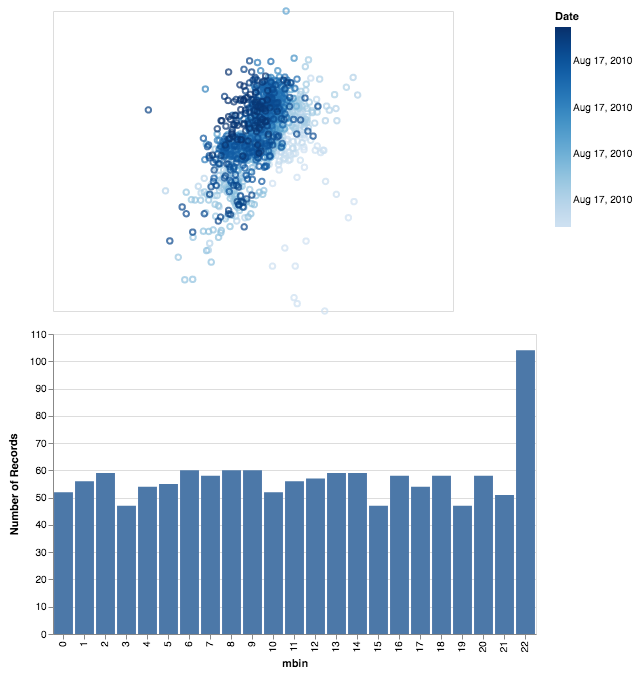

In [9]:
brush = alt.selection(type='interval', encodings=['x'])

points = alt.Chart().mark_point().encode(
    longitude = 'Longitude',
    latitude = 'Latitude',
    color='Date'
).transform_filter(
    brush.ref()
)

bars = alt.Chart().mark_bar().encode(
    x= 'mbin:N',
    y='count()'
).properties(
    selection=brush
)

alt.vconcat(points, bars,
    data=aug16
).transform_bin(
    "mbin",
    field="Hour",
    bin=alt.Bin(maxbins=25)
)

Set the numbers of minutes to be binned

In [10]:
nmin = 10
smin = str(nmin) + 'T'

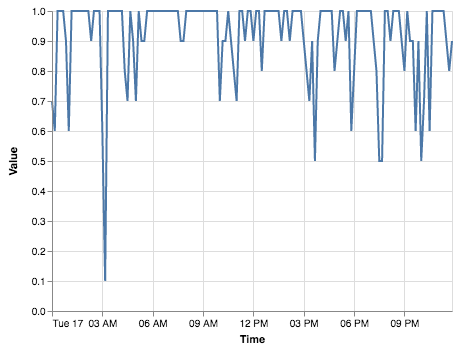

In [11]:
df = pd.DataFrame({'Time': aug16['Date'], 'Value': np.repeat(1, aug16.shape[0])})
df.set_index('Time', inplace=True)
df.tail()
df_group = df.groupby(pd.Grouper(level='Time', freq=smin))['Value'].agg('sum')   
df_group.dropna(inplace=True)
df_group = df_group.to_frame().reset_index()
df_group['Value'] = (1.0 / nmin) * df_group['Value']

alt.Chart(df_group).mark_line().encode(
    x='Time',
    y='Value'
)

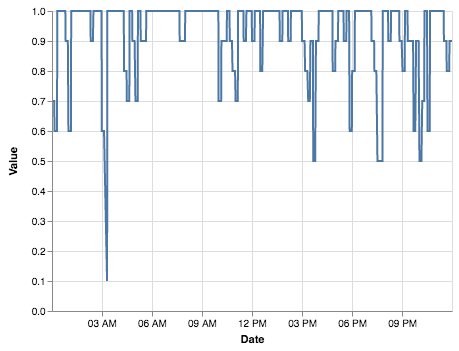

In [12]:
dfInterp = pd.merge_asof(aug16.sort_values(by="Date"), df_group.sort_values(by="Time"), \
    left_on="Date",right_on="Time")

alt.Chart(dfInterp).mark_line().encode(
    x='Date',
    y='Value'
)

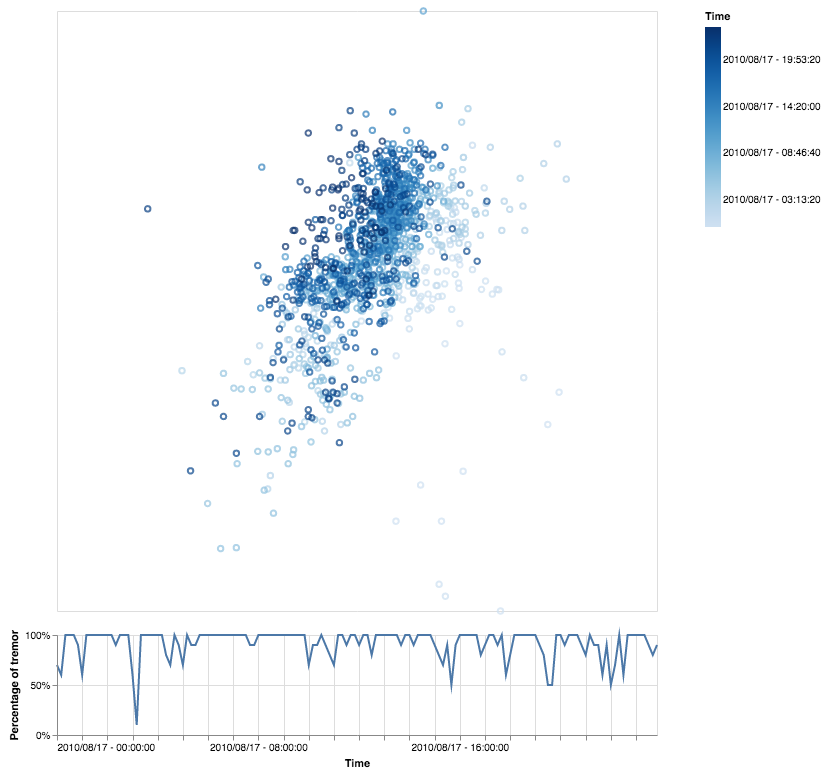

In [13]:
brush = alt.selection(type='interval', encodings=['x'])

points = alt.Chart().mark_point().encode(
    longitude = 'Longitude',
    latitude = 'Latitude',
    color=alt.Color('Time', legend=alt.Legend(format='%Y/%m/%d - %H:%M:%S'))
).transform_filter(
    brush.ref()
).properties(
    width=600,
    height=600
)

bars = alt.Chart().mark_line().encode(
    x=alt.X('Time', axis=alt.Axis(format='%Y/%m/%d - %H:%M:%S', title='Time')),
    y=alt.Y('Value', axis=alt.Axis(format='%', title='Percentage of tremor'))
).properties(
    width=600,
    height=100,
    selection=brush
)

alt.vconcat(points, bars,
    data=dfInterp
)

# Part 2
Let us read geopandas files with altair now

In [27]:
import geopandas as gpd

In [28]:
path = gpd.datasets.get_path('naturalearth_lowres')
gdf = gpd.read_file(path)
gdf.head()

pop_est      continent                  name iso_a3  gdp_md_est  \
0  28400000.0           Asia           Afghanistan    AFG     22270.0   
1  12799293.0         Africa                Angola    AGO    110300.0   
2   3639453.0         Europe               Albania    ALB     21810.0   
3   4798491.0           Asia  United Arab Emirates    ARE    184300.0   
4  40913584.0  South America             Argentina    ARG    573900.0   

                                            geometry  
0  POLYGON ((61.21081709172574 35.65007233330923,...  
1  (POLYGON ((16.32652835456705 -5.87747039146621...  
2  POLYGON ((20.59024743010491 41.85540416113361,...  
3  POLYGON ((51.57951867046327 24.24549713795111,...  
4  (POLYGON ((-65.50000000000003 -55.199999999999...

In [33]:
gdf.dtypes

pop_est       float64
continent      object
name           object
iso_a3         object
gdp_md_est    float64
geometry       object
dtype: object

In [36]:
import json
# dump as json
json_gdf = gdf.to_json()
# load as a GeoJSON object.
json_features = json.loads(json_gdf)
# parse variable `features` from json_features to `alt.Data`
data_geo = alt.Data(values=json_features['features'])
# plot map, where variables ares nested within `properties`, 
# plot map, where variables ares nested within `properties`, 
alt.Chart(data_geo).mark_geoshape(
    fill='lightgray',
    stroke='white'
).properties(
    projection={'type': 'albersUsa'},
    width=700,
    height=400
).encode(
    color='pop_est:Q')

<VegaLite 2 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


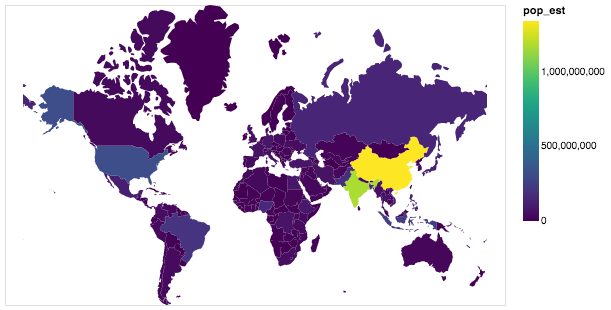

In [2]:
import altair as alt
import geopandas as gpd
import gpdvega

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# GeoDataFrame could be passed as usual pd.DataFrame
alt.Chart(world[world.continent!='Antarctica']).mark_geoshape(
).project(
).encode(
    color='pop_est', # shorthand infer types as for regular pd.DataFrame
    tooltip='id:Q' # GeoDataFrame.index is accessible as id
).properties(
    width=500,
    height=300
)

In [3]:
fp = "../data/geodata/WA_BC_Plus_shoreline.shp"
data = gpd.read_file(fp)

In [4]:
data.head()

id  level source  parent_id  sibling_id          area  \
0    2      1    WVS         -1           2  2.015474e+07   
1   50      1    WVS         -1          50  3.205080e+04   
2   86      1    WVS         -1          86  9.304681e+03   
3  104      1    WVS         -1         104  6.821802e+03   
4  171      1    WVS         -1         171  2.979102e+03   

                                            geometry  
0  (POLYGON ((-131.805028 55.910417, -131.800833 ...  
1  POLYGON ((-128.052694 50.86738900000003, -128....  
2  POLYGON ((-133.031639 54.18497200000007, -133....  
3  POLYGON ((-132.6381476946905 55.92117463484266...  
4  POLYGON ((-131.1708889999999 55.91163900000004...

In [8]:
data.rename(columns={'id' : 'id0'}, inplace=True)
data.head()

id0  level source  parent_id  sibling_id          area  \
0    2      1    WVS         -1           2  2.015474e+07   
1   50      1    WVS         -1          50  3.205080e+04   
2   86      1    WVS         -1          86  9.304681e+03   
3  104      1    WVS         -1         104  6.821802e+03   
4  171      1    WVS         -1         171  2.979102e+03   

                                            geometry  
0  (POLYGON ((-131.805028 55.910417, -131.800833 ...  
1  POLYGON ((-128.052694 50.86738900000003, -128....  
2  POLYGON ((-133.031639 54.18497200000007, -133....  
3  POLYGON ((-132.6381476946905 55.92117463484266...  
4  POLYGON ((-131.1708889999999 55.91163900000004...

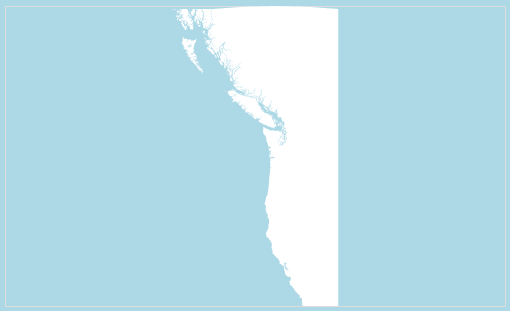

In [16]:
# GeoDataFrame could be passed as usual pd.DataFrame
alt.Chart(data).mark_geoshape(
).project(
).encode(
    color=alt.value('white')
).properties(
    width=500,
    height=300
).configure(background='lightblue')